In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
data = pd.read_csv('./anomaly_dataset.csv')

In [4]:
data

,Velocity,Direction,label
0,0.265570,4.227153,0
1,0.300980,3.628604,0
2,0.171430,2.784595,0
3,0.319400,3.400146,0
4,0.216679,3.591772,0
...,...,...,...
18030,0.231716,2.996458,0
18031,0.118288,3.533865,0
18032,0.160724,3.785585,0
18033,0.130927,3.427468,0


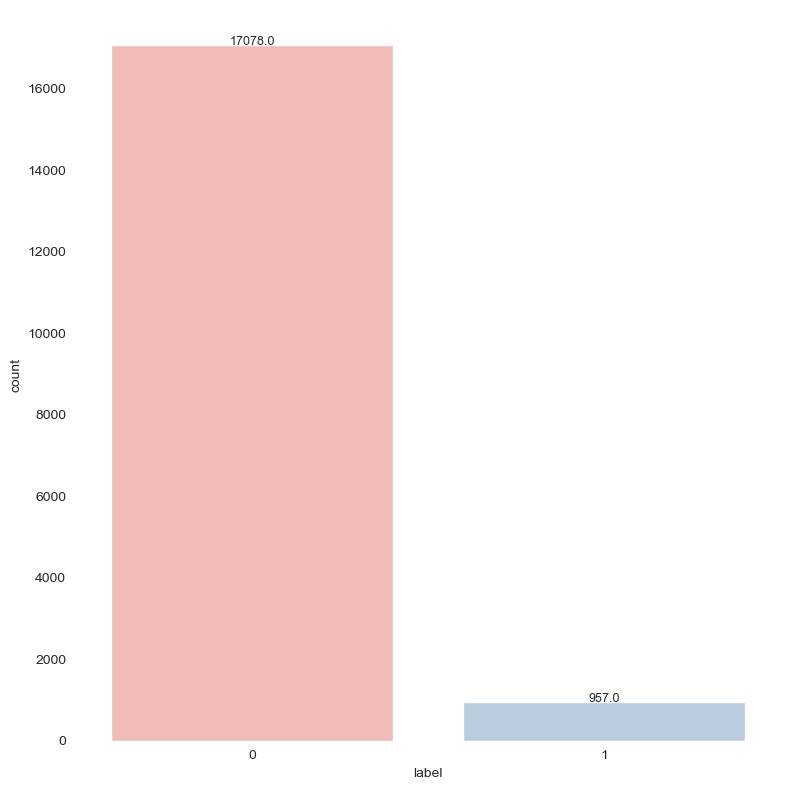

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8))
plt.rcParams['axes.facecolor'] = 'white'
ax = sns.countplot(x='label', data=data, palette='Pastel1')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.tight_layout()

In [6]:
data = data.sort_values(by='label')
data = data.reset_index(drop=True)

In [7]:
data

,Velocity,Direction,label
0,0.265570,4.227153,0
1,0.164145,3.029955,0
2,0.126235,2.731753,0
3,0.176324,3.829839,0
4,0.133068,3.754392,0
...,...,...,...
18030,4.171711,4.430516,1
18031,12.059835,4.269800,1
18032,4.137699,4.474006,1
18033,7.814695,4.788406,1


In [8]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_train = X[:int(0.8*len(X))]
X_test = X[int(0.8*len(X)):]
y_train = y[:int(0.8*len(y))]
y_test = y[int(0.8*len(y)):]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(len(y_train[y_train == 1]))
print(len(y_train[y_train == 0]))
print(len(y_test[y_test == 1]))
print(len(y_test[y_test == 0]))

(14428, 2)
(3607, 2)
(14428,)
(3607,)
0
14428
957
2650


In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def return_result(y_true, y_pred):
    performance = {}
    performance['acc'] = accuracy_score(y_true=y_true, y_pred=y_pred)
    performance['precision_score'] = precision_score(y_true=y_true,y_pred=y_pred)
    performance['recall_score'] = recall_score(y_true=y_true,y_pred=y_pred)
    performance['f1_score'] = f1_score(y_true=y_true,y_pred=y_pred)
    
    return performance

def cf_vis(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cf, annot=True, fmt='d', cmap='Pastel1')
    
    return cf

In [10]:
from sklearn.svm import OneClassSVM

one_class_svm = OneClassSVM(nu=0.01, kernel = 'rbf', gamma = 'auto')
one_class_svm.fit(X_train)

OneClassSVM(gamma='auto', nu=0.01)

acc : 0.8821735514277793
precision_score : 0.5966562173458725
recall_score : 0.9360655737704918
f1_score : 0.7287811104020421
[[2611   39]
 [ 386  571]]


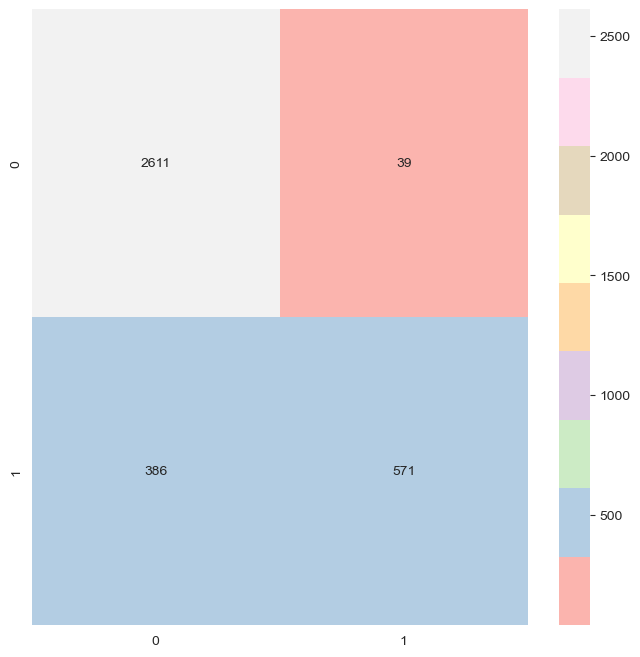

In [11]:
y_pred = one_class_svm.predict(X_test)
y_pred = [1 if i==-1 else 0 for i in y_pred]

performance = return_result(y_pred, y_test)

for k, v in performance.items():
    print(k, ':', v)

print(cf_vis(y_test, y_pred))

In [14]:
# Predict the anomalies
prediction = one_class_svm.predict(X_test)
# Change the anomalies' values to make it consistent with the true values
prediction = [1 if i==-1 else 0 for i in prediction]
# Check the model performance
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.87      0.99      0.92      2650
           1       0.94      0.60      0.73       957

    accuracy                           0.88      3607
   macro avg       0.90      0.79      0.83      3607
weighted avg       0.89      0.88      0.87      3607



In [15]:
# Get the scores for the testing dataset
score = one_class_svm.score_samples(X_test)
# Check the score for 2% of outliers
score_threshold = np.percentile(score, 2)
print(f'The customized score threshold for 2% of outliers is {score_threshold:.2f}')
# Check the model performance at 2% threshold
customized_prediction = [1 if i < score_threshold else 0 for i in score]
# # Check the prediction performance
print(classification_report(y_test, customized_prediction))

The customized score threshold for 2% of outliers is 0.00
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      2650
           1       1.00      0.08      0.14       957

    accuracy                           0.75      3607
   macro avg       0.87      0.54      0.50      3607
weighted avg       0.82      0.75      0.67      3607



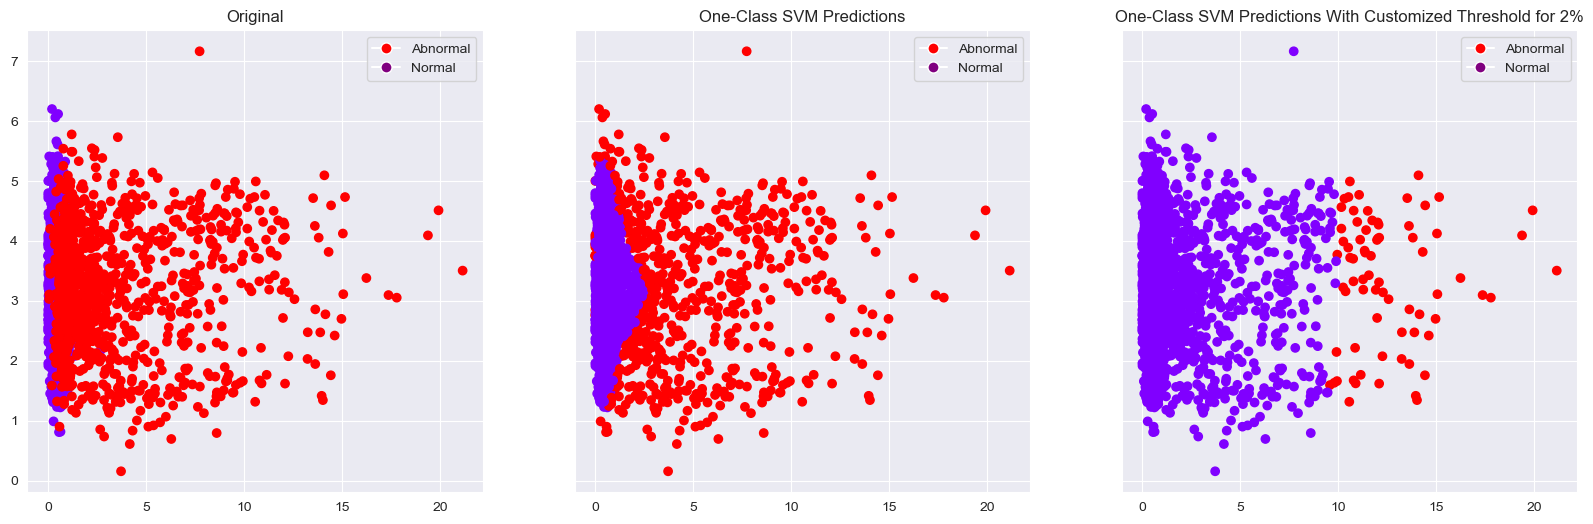

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True, figsize=(20, 6))


ax0.set_title('Original')
scatter0 = ax0.scatter(df_test['Velocity'], df_test['Direction'], c=df_test['y_test'], cmap='rainbow')


ax1.set_title('One-Class SVM Predictions')
scatter1 = ax1.scatter(df_test['Velocity'], df_test['Direction'], c=df_test['one_class_svm_prediction'], cmap='rainbow')


ax2.set_title('One-Class SVM Predictions With Customized Threshold for 2%')
scatter2 = ax2.scatter(df_test['Velocity'], df_test['Direction'], c=df_test['one_class_svm_prediction_cutomized'], cmap='rainbow')


abnormal_patch = plt.Line2D([0], [0], marker='o', color='w', label='Abnormal', markerfacecolor='r', markersize=8)
normal_patch = plt.Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='purple', markersize=8)
ax0.legend(handles=[abnormal_patch, normal_patch], loc='upper right')
ax1.legend(handles=[abnormal_patch, normal_patch], loc='upper right')
ax2.legend(handles=[abnormal_patch, normal_patch], loc='upper right')

plt.show()
